This notebook is used to play around with different transpilation options.

#### Play around with other transpilation options just to get an idea of what works well

In [1]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis, HLSConfig
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, transpile
from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.primitives import Estimator, Sampler

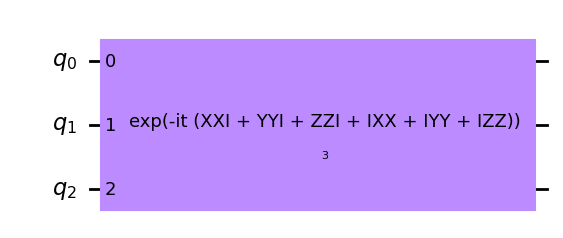

In [2]:
# Make 3-qubit Heisenberg Ham to test and corresponding PauliEvolutionGates.
test_time_evolve = 3
ham_terms = ["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"]

test_heisenberg_ham = SparsePauliOp(data=ham_terms, 
                                    coeffs=np.ones(len(ham_terms), dtype=int))
test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                             time=test_time_evolve,
                                             synthesis=MatrixExponential())


# Make initial circuit with PauliEvolutionGate.
qc_before = QuantumCircuit(len(ham_terms[0]))
qc_before.append(test_paulievolutiongate, range(len(ham_terms[0])))

qc_before.draw("mpl", filename="before.png")

In [3]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

In [4]:
lin_coupling_map = CouplingMap([[0, 1], [1, 0], [1, 2], [2, 1]])
pm_other = generate_preset_pass_manager(optimization_level=2, 
                                        layout_method="trivial",
                                        coupling_map=lin_coupling_map, 
                                        approximation_degree=2,
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

In [5]:
pm_other.init.passes()

[{'passes': [<qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction at 0x13d1179b220>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.utils.error.Error at 0x13d1179b2b0>],
  'flow_controllers': {'condition'}},
 {'passes': [<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x13d116e1150>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis at 0x13d116e34c0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.basis.unroll_3q_or_more.Unroll3qOrMore at 0x13d116e2b90>],
  'flow_controllers': {}}]

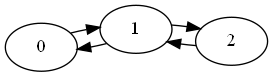

In [6]:
lin_coupling_map.draw()

In [7]:
hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":123, "involution":"countZ"})])
pm_hls = PassManager()
pm_hls.append(HighLevelSynthesis(hls_config=hls_config))
qc_hls = pm_hls.run(qc_before) 

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
--- 0.09143376350402832 seconds ---
Optimization Error:
2.2018632587639464e-11


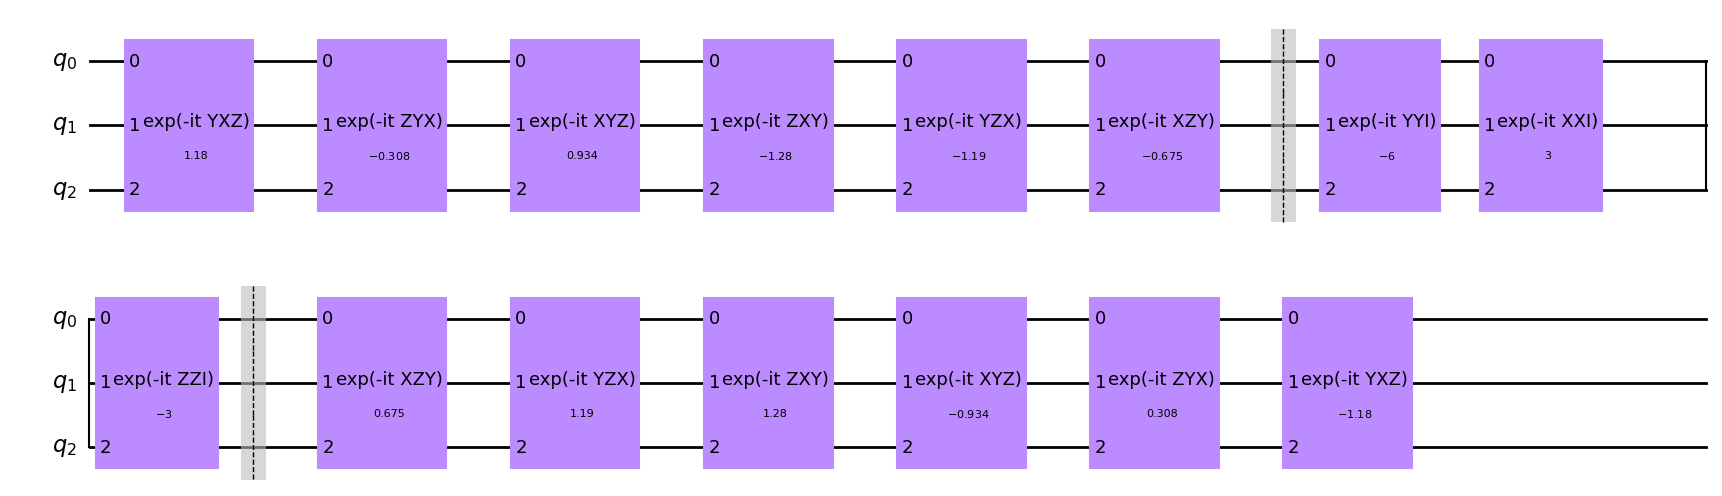

In [8]:
qc_hls.draw("mpl")

In [9]:
array_to_latex(Operator(qc_hls).data, max_size=16)

<IPython.core.display.Latex object>

In [10]:
array_to_latex(Operator(qc_before).data, max_size=16)

<IPython.core.display.Latex object>

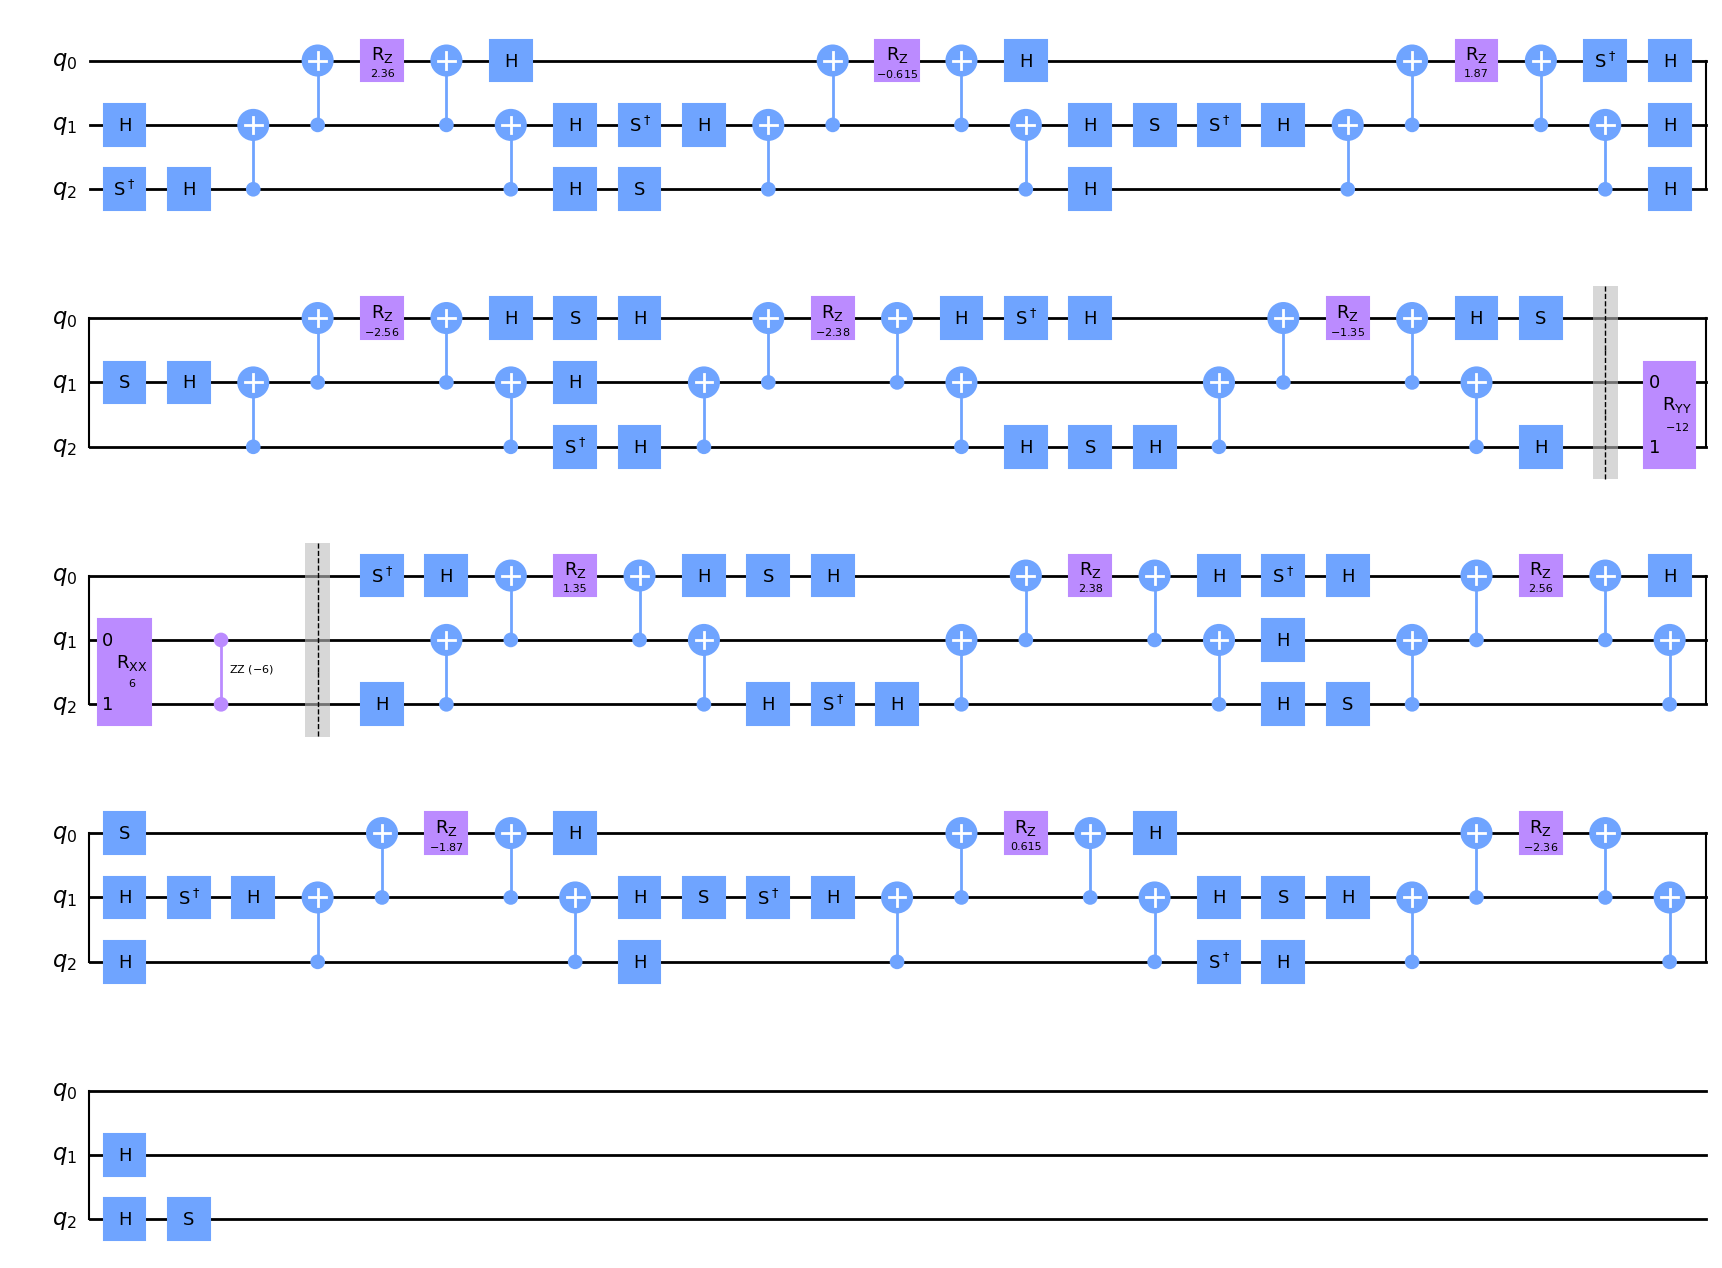

OrderedDict([('h', 48),
             ('cx', 48),
             ('sdg', 12),
             ('rz', 12),
             ('s', 12),
             ('barrier', 2),
             ('ryy', 1),
             ('rxx', 1),
             ('rzz', 1)])

In [11]:
qc_i = pm_other.init.run(qc_hls)
display(qc_i.draw("mpl"))
qc_i.count_ops()

# pm_other.init.passes()

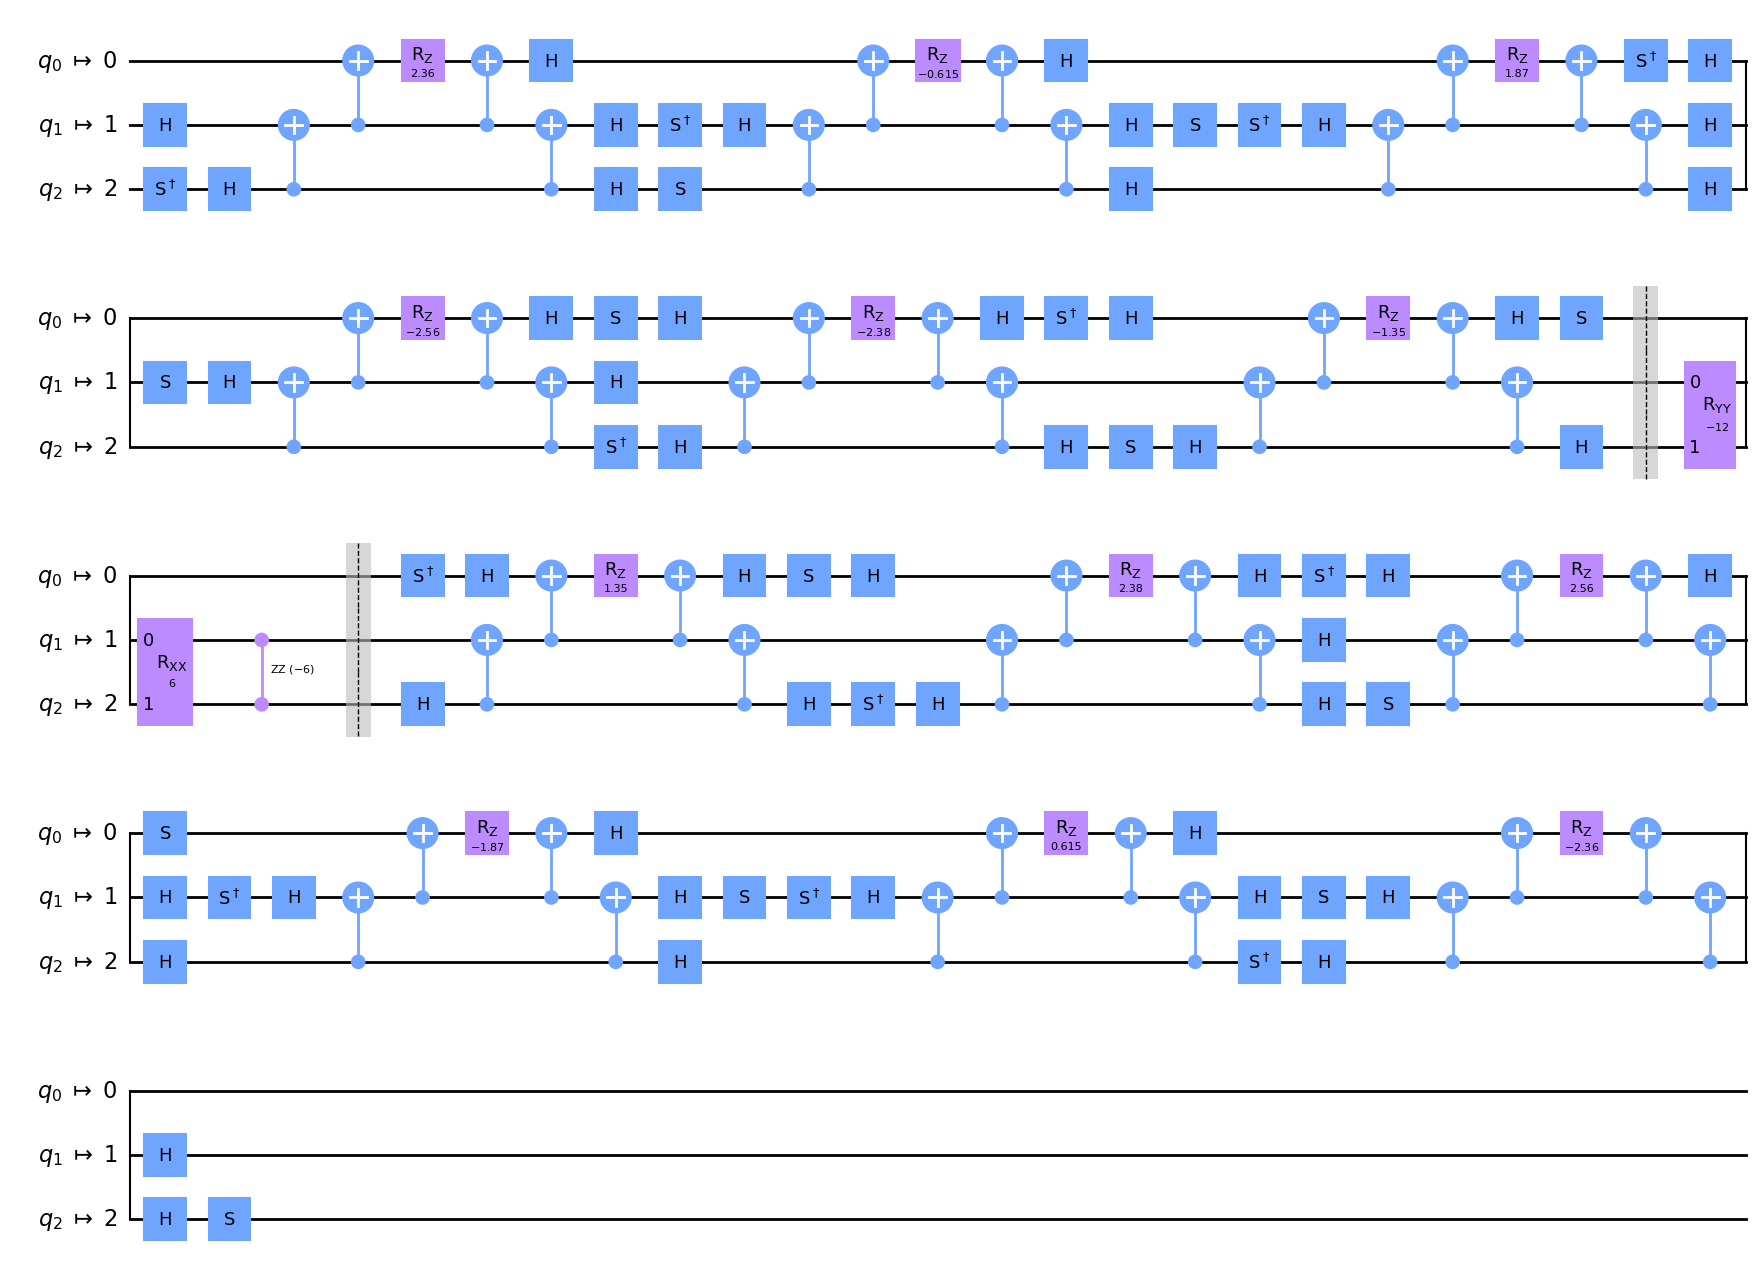

OrderedDict([('h', 48),
             ('cx', 48),
             ('sdg', 12),
             ('rz', 12),
             ('s', 12),
             ('barrier', 2),
             ('ryy', 1),
             ('rxx', 1),
             ('rzz', 1)])

In [12]:
qc_l = pm_other.layout.run(qc_i) #replace arg with qc_i if init stage included
display(qc_l.draw("mpl"))
qc_l.count_ops()

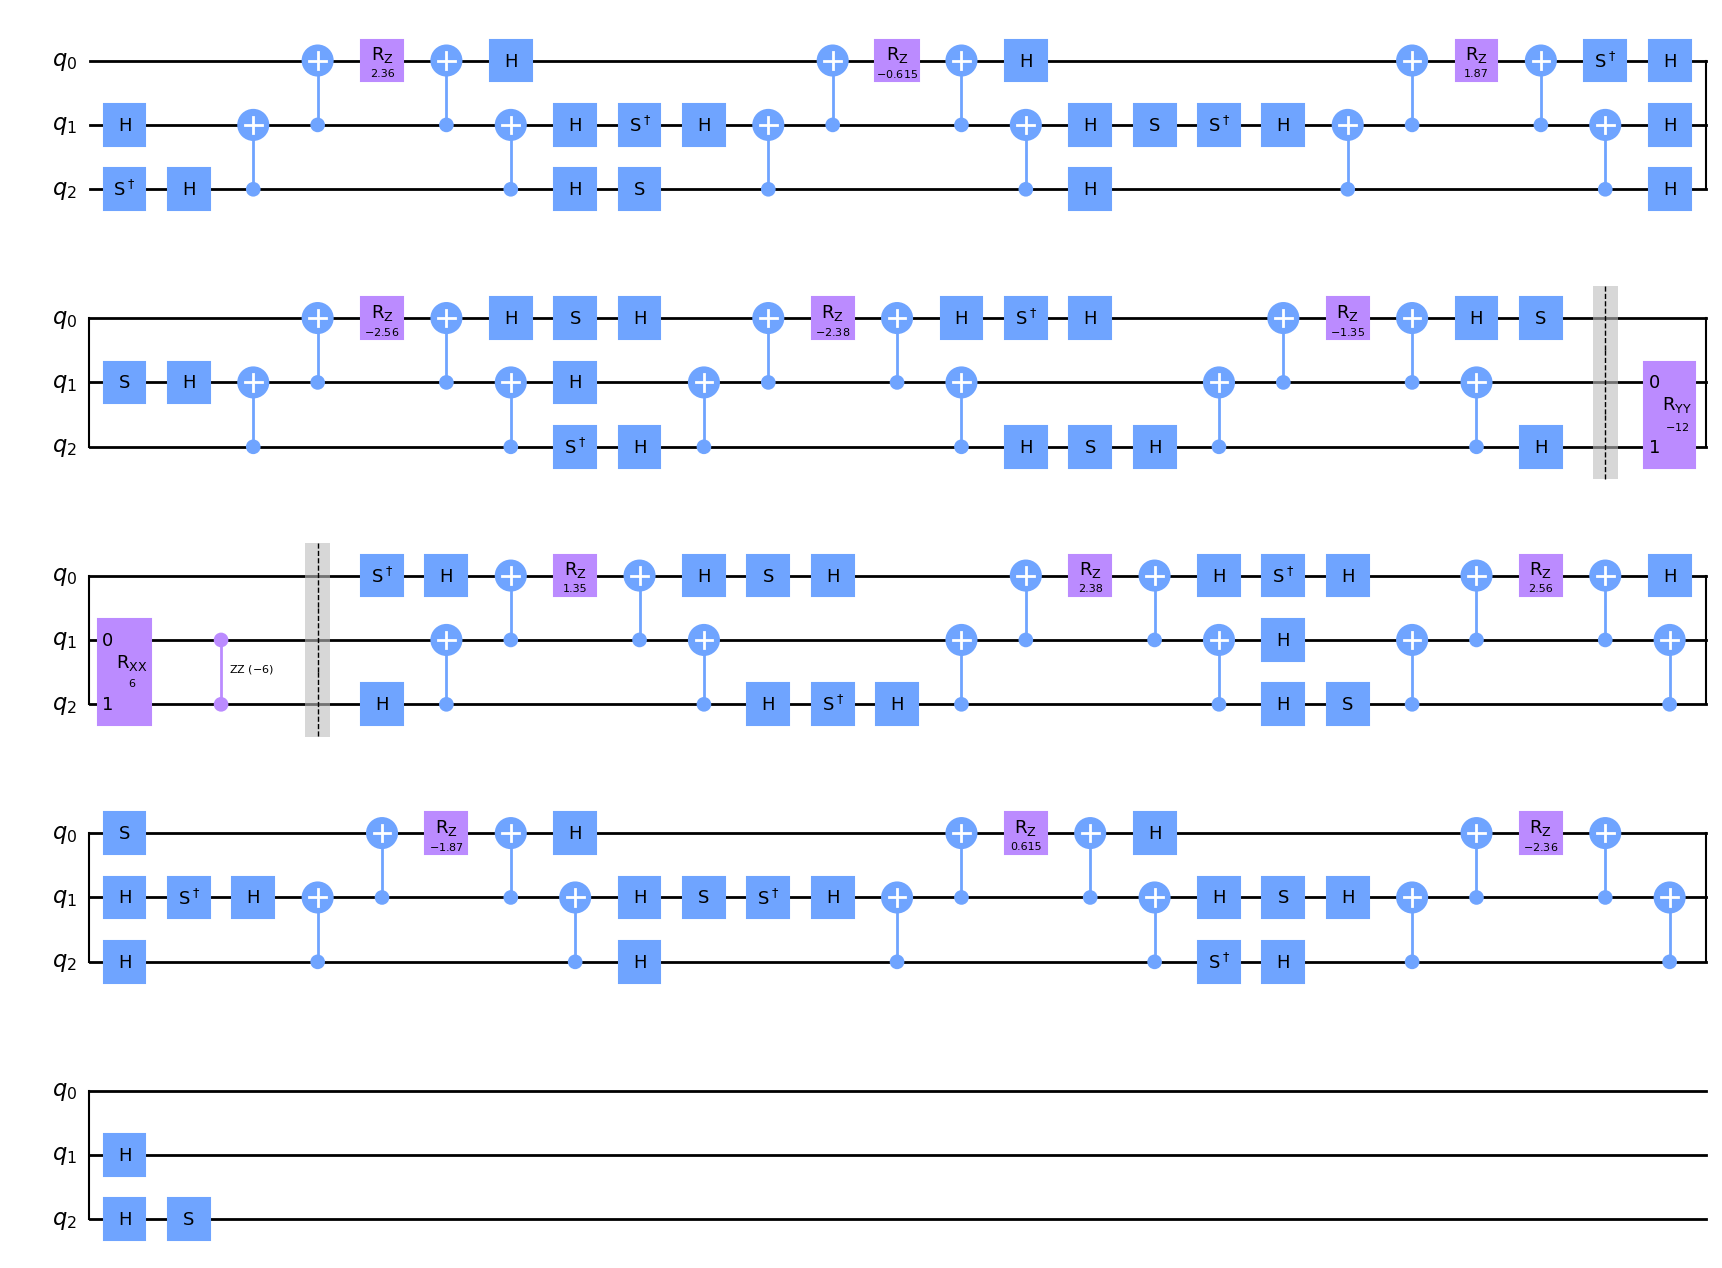

OrderedDict([('h', 48),
             ('cx', 48),
             ('sdg', 12),
             ('rz', 12),
             ('s', 12),
             ('barrier', 2),
             ('ryy', 1),
             ('rxx', 1),
             ('rzz', 1)])

In [13]:
qc_r = pm_other.routing.run(qc_l)
display(qc_r.draw("mpl"))
qc_r.count_ops()

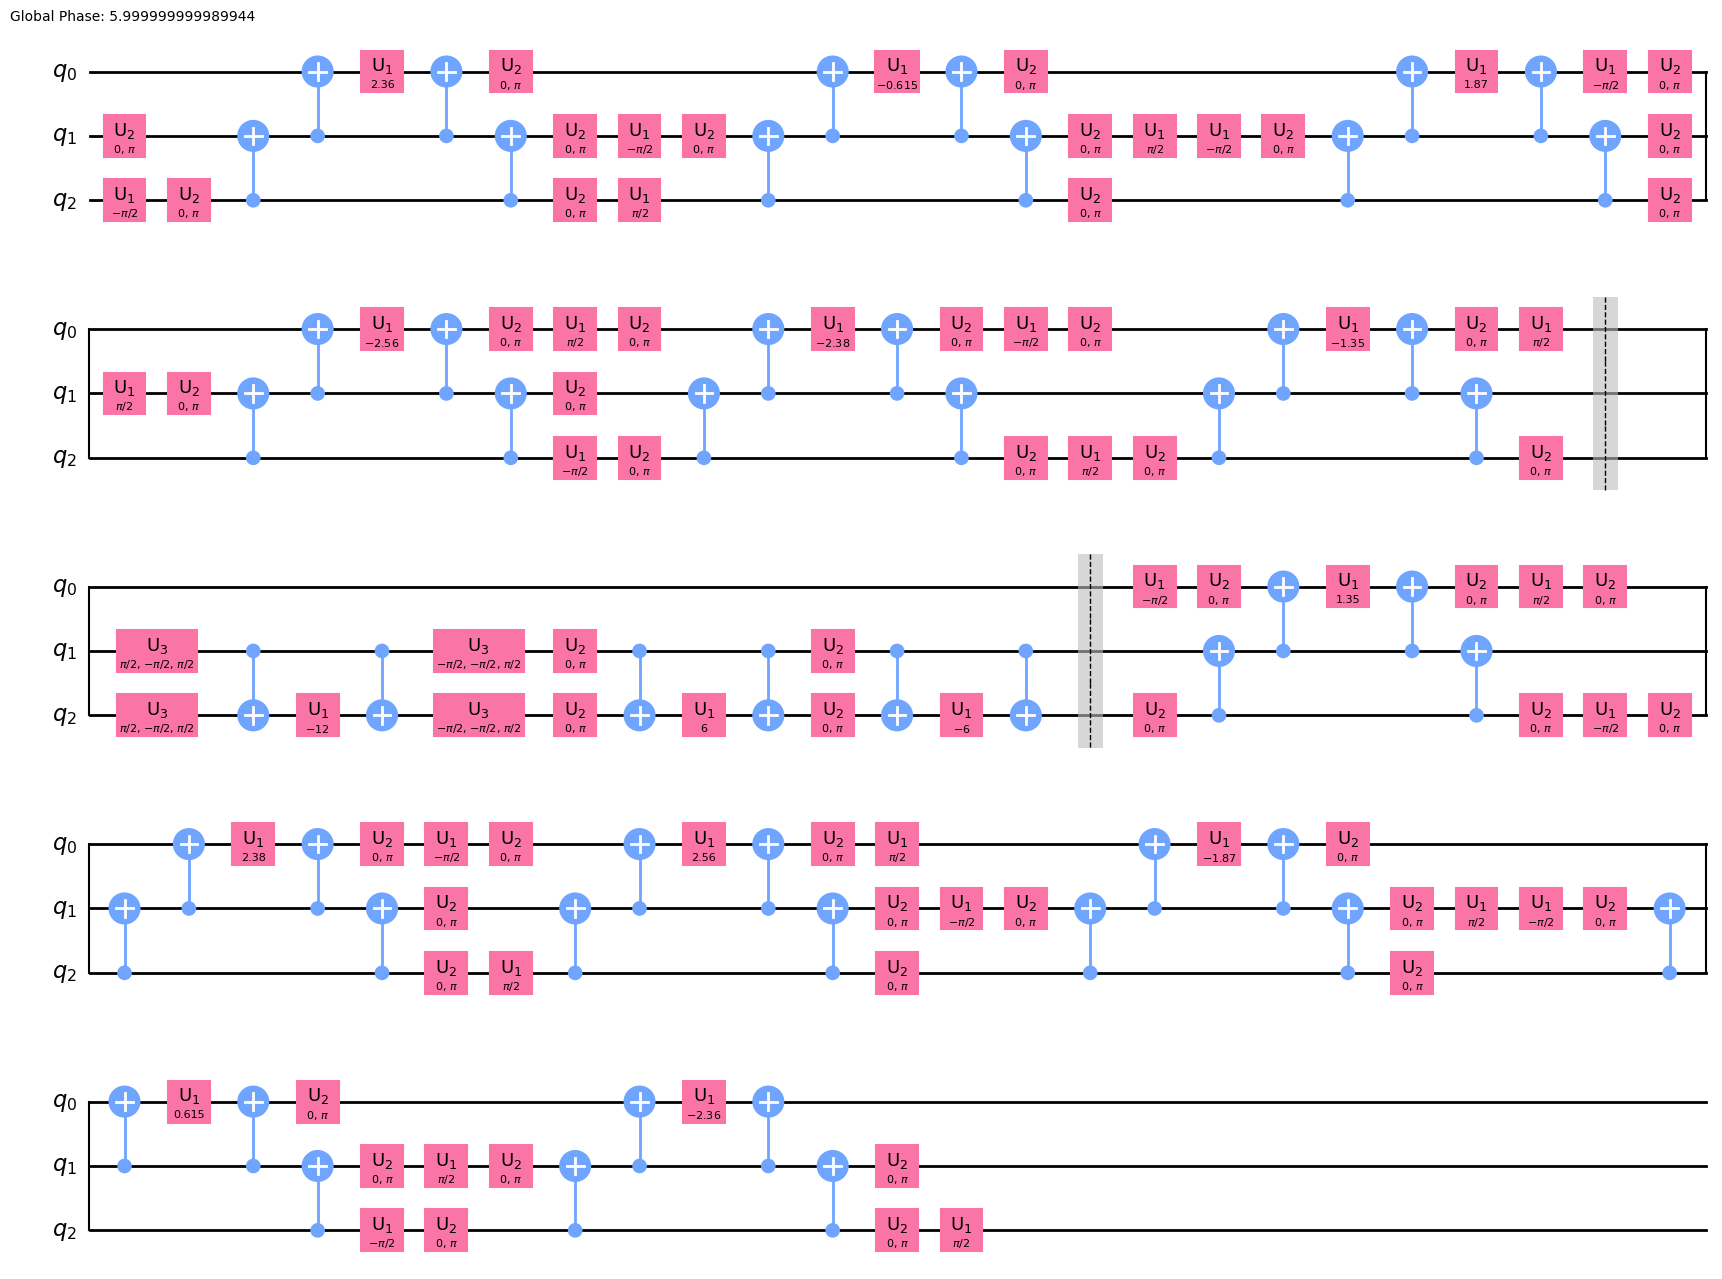

OrderedDict([('cx', 54), ('u2', 52), ('u1', 39), ('u3', 4), ('barrier', 2)])

In [14]:
qc_t = pm_other.translation.run(qc_r)
display(qc_t.draw("mpl"))
qc_t.count_ops()

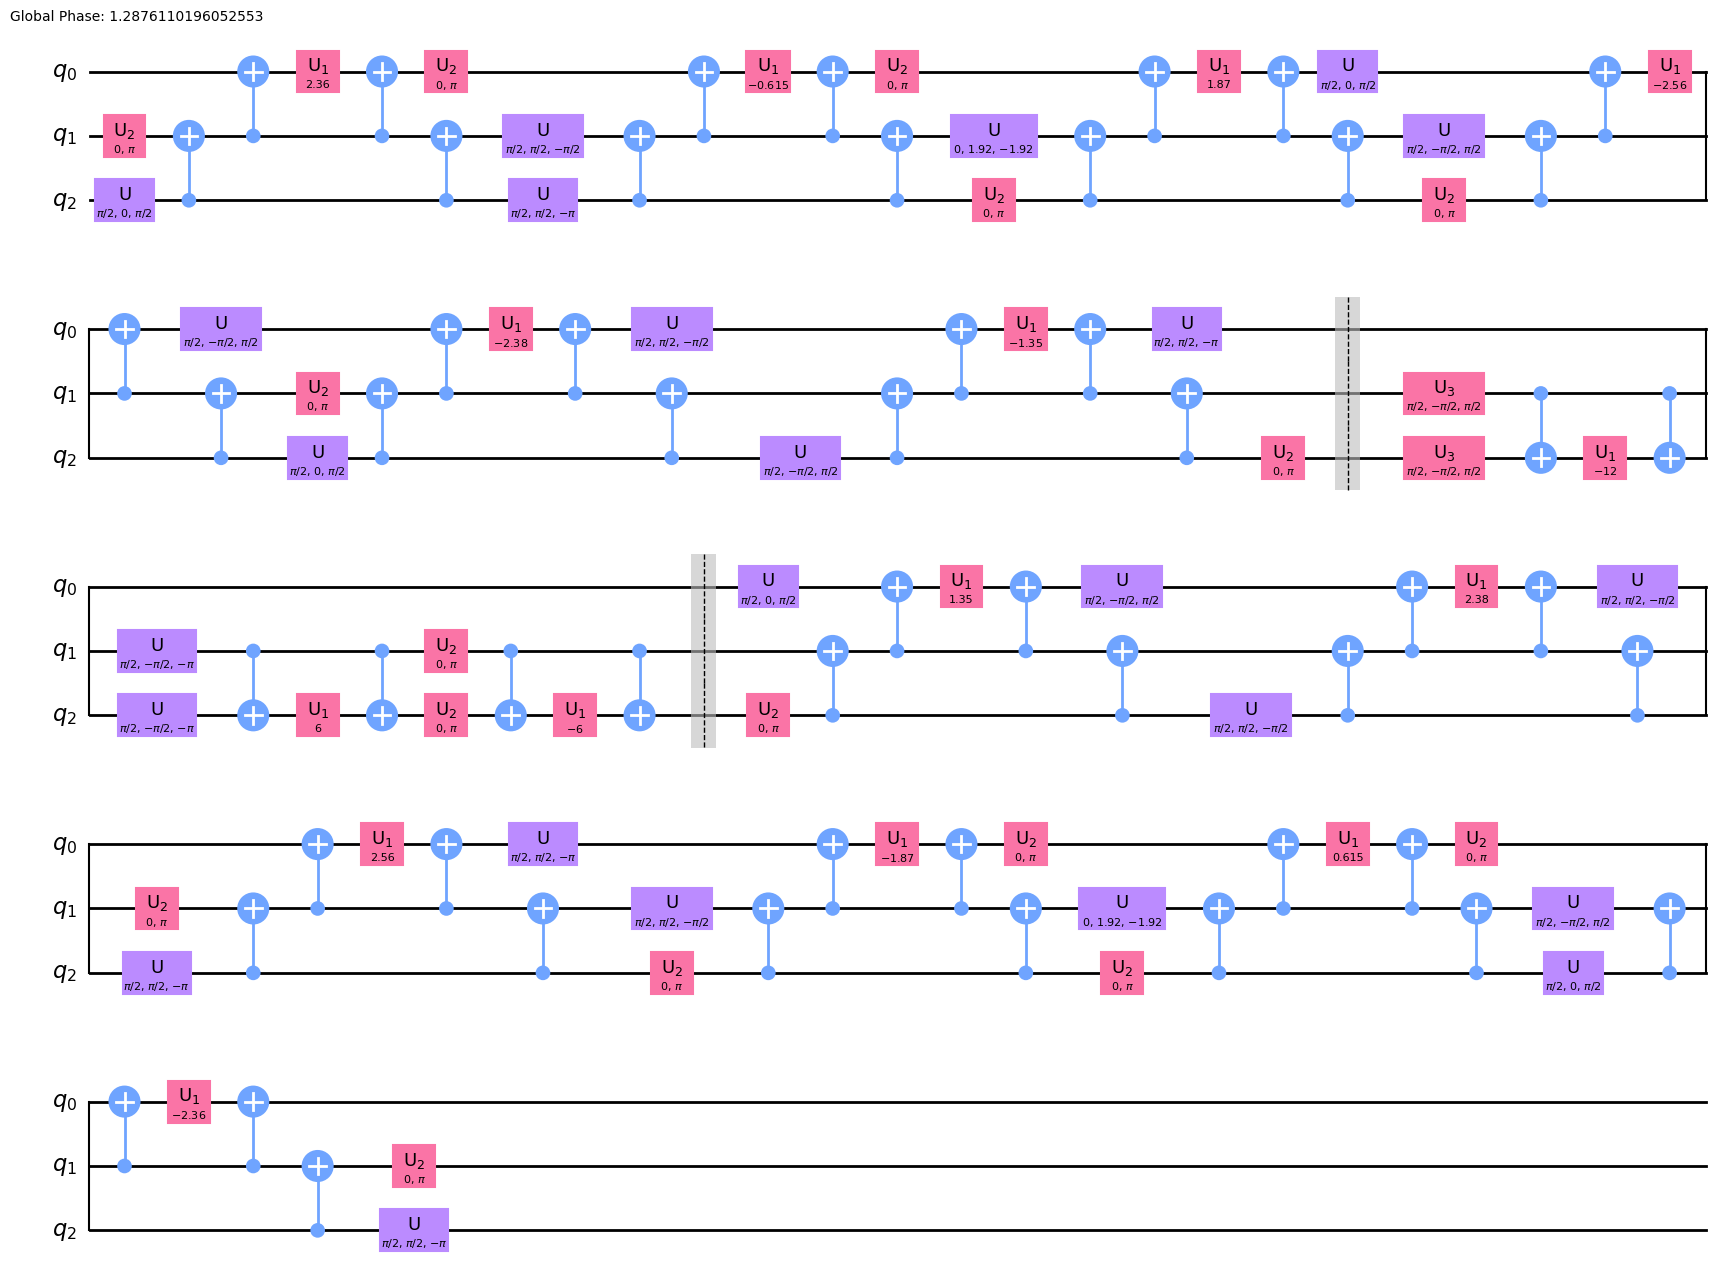

OrderedDict([('cx', 54),
             ('u', 24),
             ('u2', 16),
             ('u1', 15),
             ('barrier', 2),
             ('u3', 2)])

In [15]:
qc_o = pm_other.optimization.run(qc_t)
display(qc_o.draw("mpl"))
qc_o.count_ops()

In [16]:
# running `approximation_degree=...` after optimization stage does nothing
# also tried with other stages with no effect

pm_us = PassManager()
pm_us.append(UnitarySynthesis(approximation_degree=1)) # 0 for maximal approximation
qc_us = pm_us.run(qc_o)
qc_us.count_ops()

OrderedDict([('cx', 54),
             ('u', 24),
             ('u2', 16),
             ('u1', 15),
             ('barrier', 2),
             ('u3', 2)])

In [17]:
array_to_latex(Operator(qc_o).data)

<IPython.core.display.Latex object>

In [18]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

In [19]:
np.abs(np.trace(Operator(qc_o).data @ Operator(qc_before).data.conjugate().transpose()))/(2**len(ham_terms[0]))

0.9999999999997925

In [20]:
def csx_cartan_3qNN_3qlin(size):

    """Generate many cartan-decomposed circuits for a 3 qubit nearest-neighbor Hamiltonian transpiled
    to a 3q linear coupling map topology, and evaluate the performance of the decomposition/transpilation 
    procedure by obtaining the number of CX of the resulting circuit. For a given set of cartan/transpilation 
    options, store the #CX in a list. Finally, collect each of those lists together into a dict,
    where the key is a bumber labeling the cartan/transpilation specifications, and the value is 
    the corresponding #CX list.

    The complete list of cartan/other transpilation combations is shown below:

    Int | Cartan (k_ordering, h_starting) | Other Transp (default, unless specified)
    ----------------------------------------------------------------------------------------------------
    0   | (random, random) | -
    1   | (lexicographic, random) | -
    2   | (random, random) | approximation_degree=0
    3   | (random, random) | optimization_level=3
    
    where default corresponds to the following options in a staged passmanager:
        layout_method="trivial",
        coupling_map=lin_coupling_map, 
        approximation_degree=1,
        routing_method="sabre",
        translation_method="unroller",
        optimization_level=2, 
        basis_gates="['u1', 'u2', 'u3', 'cx']",
        seed_transpiler=1
    
    Parameters:
        size (Int): number of circuits to generate for each cartan/transpilation specification.
        
    Returns:
        Dict{Int, List}: dict of list of cxs. Each sublist has length `size` containing the cx counts. 
        There should be some variance within each sublist due to various sources of stochasticity.
    """    


    return

# Appendix: run all the stages of the passmanager except don't do the cartan decomp to begin with

we see that for small number of qubits, the default transpilation for unroll3qormore (using column by column decomp outlined by https://arxiv.org/pdf/1501.06911.pdf) works better than.

In [21]:
pm_other.init.passes()

[{'passes': [<qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction at 0x13d1179b220>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.utils.error.Error at 0x13d1179b2b0>],
  'flow_controllers': {'condition'}},
 {'passes': [<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x13d116e1150>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis at 0x13d116e34c0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.basis.unroll_3q_or_more.Unroll3qOrMore at 0x13d116e2b90>],
  'flow_controllers': {}}]

In [22]:
# Get the third pass from the list
# pass_to_run = pm_other.init.passes()[4]['passes'][0]

# Create a new PassManager with only the desired pass
# new_pass_manager = PassManager(pass_to_run)

# Run the pass
# result = new_pass_manager.run(qc_before) 
# result..draw("mpl")

In [23]:
# pass_to_run.name

In [24]:
qc_i = pm_other.init.run(qc_before)
# display(qc_i.draw("mpl"))
qc_i.count_ops()

OrderedDict([('u', 14),
             ('cx', 11),
             ('circuit-440', 1),
             ('circuit-449', 1),
             ('circuit-458', 1),
             ('circuit-469', 1)])

In [25]:
qc_l = pm_other.layout.run(qc_i) #replace arg with qc_i if init stage included
# display(qc_l.draw("mpl"))
qc_l.count_ops()

OrderedDict([('u', 14),
             ('cx', 11),
             ('circuit-440', 1),
             ('circuit-449', 1),
             ('circuit-458', 1),
             ('circuit-469', 1)])

In [26]:
qc_r = pm_other.routing.run(qc_l)
# display(qc_r.draw("mpl"))
qc_r.count_ops()

OrderedDict([('u', 14),
             ('cx', 11),
             ('swap', 6),
             ('circuit-440', 1),
             ('circuit-449', 1),
             ('circuit-458', 1),
             ('circuit-469', 1)])

In [27]:
qc_t = pm_other.translation.run(qc_r)
# display(qc_t.draw("mpl"))
qc_t.count_ops()

OrderedDict([('cx', 38), ('u3', 26), ('u', 14)])

In [28]:
qc_o = pm_other.optimization.run(qc_t)
# display(qc_o.draw("mpl"))
qc_o.count_ops()

OrderedDict([('cx', 34), ('u3', 26), ('u', 9)])

In [29]:
array_to_latex(Operator(qc_o).data)

<IPython.core.display.Latex object>

In [30]:
# Compare with pre-transpiled circuit
array_to_latex(Operator(qc_before).data)


<IPython.core.display.Latex object>

In [32]:
from mqt import qcec

qcec.verify(qc_before, qc_o)

{
  "check_time": 0.0070266,
  "equivalence": "equivalent",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.0001849,
  "simulations": {
    "performed": 0,
    "started": 8
  }
}

In [31]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", 
#                                   token='219d6c8d75d6eac3417ed9bc50414b42b1b464ded94ed3f48dd8cfb16e85366e1b4e707dec6bb127ab03b3223e0f9c41a405f6ebcdb7275bb98f9f1b287016c3', 
#                                   instance="ibm-q/open/main",
#                                   overwrite=True)
# QiskitRuntimeService.saved_accounts()